The Square Model Using GRU and LSTM
====================================

## Download Untility Files for Plotting and Data Generation

Download these utility functions first and place them in the same directory as this notebook. 

In [1]:
from IPython.display import FileLink, FileLinks

In [2]:
FileLink('plots.py')

c:\Users\wei\jupyter_book\cits4012\cits4012_natural_language_processing\cits4012_natural_language_processing\LSTM\plots.py

In [3]:
FileLink('util.py')

c:\Users\wei\jupyter_book\cits4012\cits4012_natural_language_processing\cits4012_natural_language_processing\LSTM\util.py

In [4]:
FileLink('replay.py')

c:\Users\wei\jupyter_book\cits4012\cits4012_natural_language_processing\cits4012_natural_language_processing\LSTM\replay.py

## Imports

In [5]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torch.nn.utils import rnn as rnn_utils
from util import StepByStep
from plots import *

## Synthetic Data Generation

### Sequence Generation Function

This function generate sequences, each of four data points, located close to a perfect square with four corners at `[-1, -1], [-1, 1], [1, 1], [1, -1]`, respectively. 

In [6]:
def generate_sequences(n=128, variable_len=False, seed=13):
    basic_corners = np.array([[-1, -1], [-1, 1], [1, 1], [1, -1]])
    np.random.seed(seed)
    bases = np.random.randint(4, size=n)
    if variable_len:
        lengths = np.random.randint(3, size=n) + 2
    else:
        lengths = [4] * n
    directions = np.random.randint(2, size=n)
    points = [basic_corners[[(b + i) % 4 for i in range(4)]][slice(None, None, d*2-1)][:l] + np.random.randn(l, 2) * 0.1 for b, d, l in zip(bases, directions, lengths)]
    return points, directions

### Training data Generation

In [7]:
points, directions = generate_sequences(n=128, seed=13)

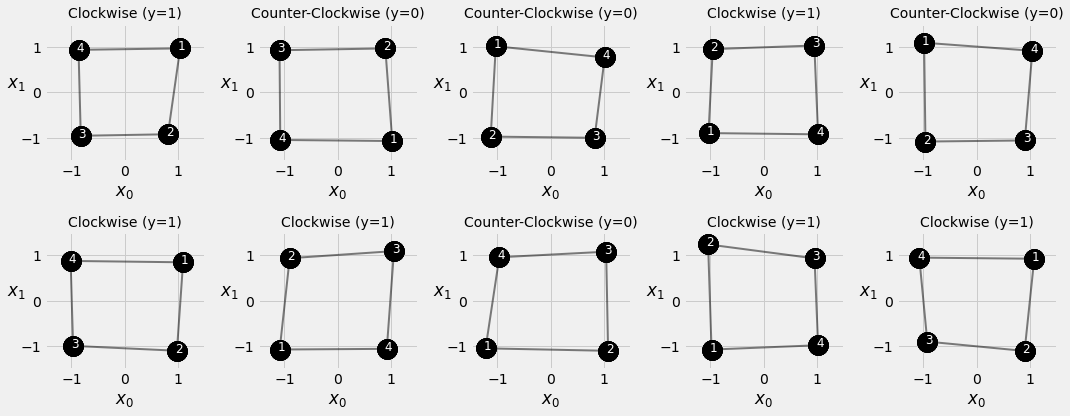

In [8]:
fig = plot_data(points, directions)

## Square Model

### Test Data Generation

In [9]:
test_points, test_directions = generate_sequences(seed=19)

### Data Preparation

In [10]:
train_data = TensorDataset(torch.as_tensor(points).float(), 
                           torch.as_tensor(directions).view(-1, 1).float())
test_data = TensorDataset(torch.as_tensor(test_points).float(),
                          torch.as_tensor(test_directions).view(-1, 1).float())

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

### Model Configuration

In [11]:
class SquareModel(nn.Module):
    def __init__(self, n_features, hidden_dim, n_outputs):
        super(SquareModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.hidden = None
        # Simple RNN
        self.basic_rnn = nn.RNN(self.n_features, self.hidden_dim, batch_first=True)
        # Classifier to produce as many logits as outputs
        self.classifier = nn.Linear(self.hidden_dim, self.n_outputs)
                
    def forward(self, X):
        # X is batch first (N, L, F)
        # output is (N, L, H)
        # final hidden state is (1, N, H)
        batch_first_output, self.hidden = self.basic_rnn(X)
        
        # only last item in sequence (N, 1, H)
        last_output = batch_first_output[:, -1]
        # classifier will output (N, 1, n_outputs)
        out = self.classifier(last_output)
        
        # final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)

In [12]:
torch.manual_seed(21)
model = SquareModel(n_features=2, hidden_dim=2, n_outputs=1)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

### Model Training

The StepByStep class encapsulated the training routine as well as the data loading into methods such as:

- `_mini_batch`
- `_make_train_step`
- `_make_val_step`

You may want to take a closer look at the `StepByStep` in the `util.py` file to learn how to factorize your code into a reusable blocks. 

In [13]:
sbs_rnn = StepByStep(model, loss, optimizer)
sbs_rnn.set_loaders(train_loader, test_loader)
sbs_rnn.train(100)

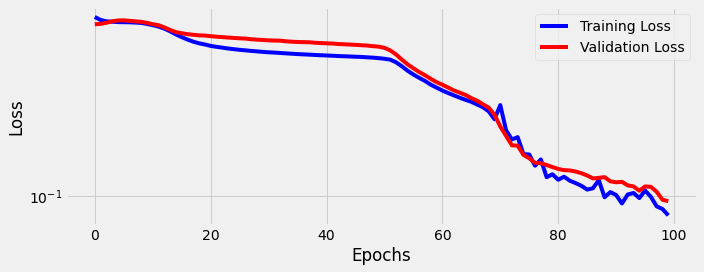

In [14]:
fig = sbs_rnn.plot_losses()

In [15]:
StepByStep.loader_apply(test_loader, sbs_rnn.correct)

tensor([[50, 53],
        [75, 75]])

### Transformed Inputs

In [16]:
class SquareModelGRU(nn.Module):
    def __init__(self, n_features, hidden_dim, n_outputs):
        super(SquareModelGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.hidden = None
        # Simple GRU
        self.basic_rnn = nn.GRU(self.n_features, self.hidden_dim, batch_first=True)
        # Classifier to produce as many logits as outputs
        self.classifier = nn.Linear(self.hidden_dim, self.n_outputs)
                
    def forward(self, X):
        # X is batch first (N, L, F)
        # output is (N, L, H)
        # final hidden state is (1, N, H)
        batch_first_output, self.hidden = self.basic_rnn(X)
        
        # only last item in sequence (N, 1, H)
        last_output = batch_first_output[:, -1]
        # classifier will output (N, 1, n_outputs)
        out = self.classifier(last_output)
        
        # final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)        

### Model Configuration & Training

In [17]:
torch.manual_seed(21)
model = SquareModelGRU(n_features=2, hidden_dim=2, n_outputs=1)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [18]:
sbs_gru = StepByStep(model, loss, optimizer)
sbs_gru.set_loaders(train_loader, test_loader)
sbs_gru.train(100)

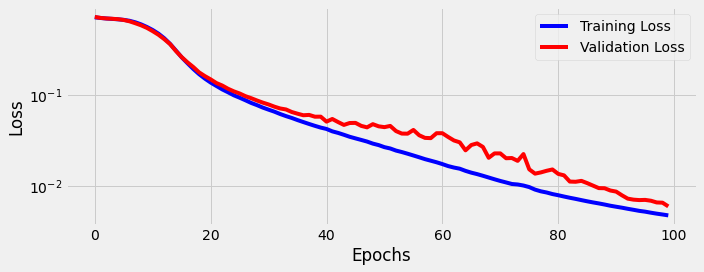

In [19]:
fig = sbs_gru.plot_losses()

In [20]:
StepByStep.loader_apply(test_loader, sbs_gru.correct)

tensor([[53, 53],
        [75, 75]])

## Visualizing the Model

### Hidden States

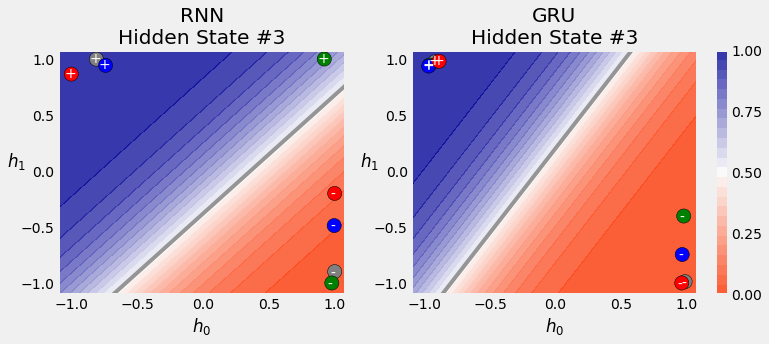

In [21]:
fig = figure20(sbs_rnn.model, sbs_gru.model)

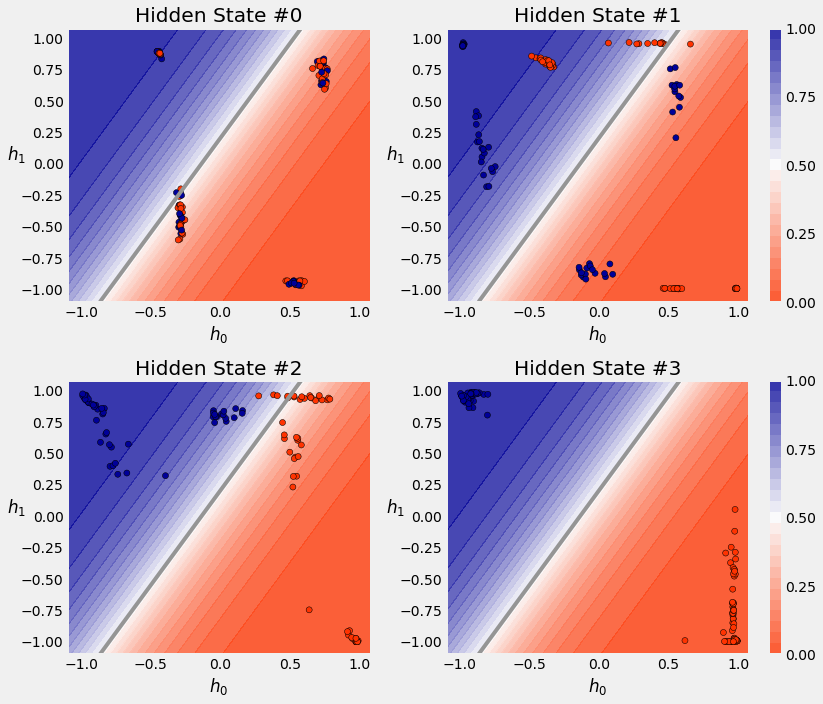

In [22]:
fig = hidden_states_contour(model, points, directions)

### Journey of a GATED Hidden State

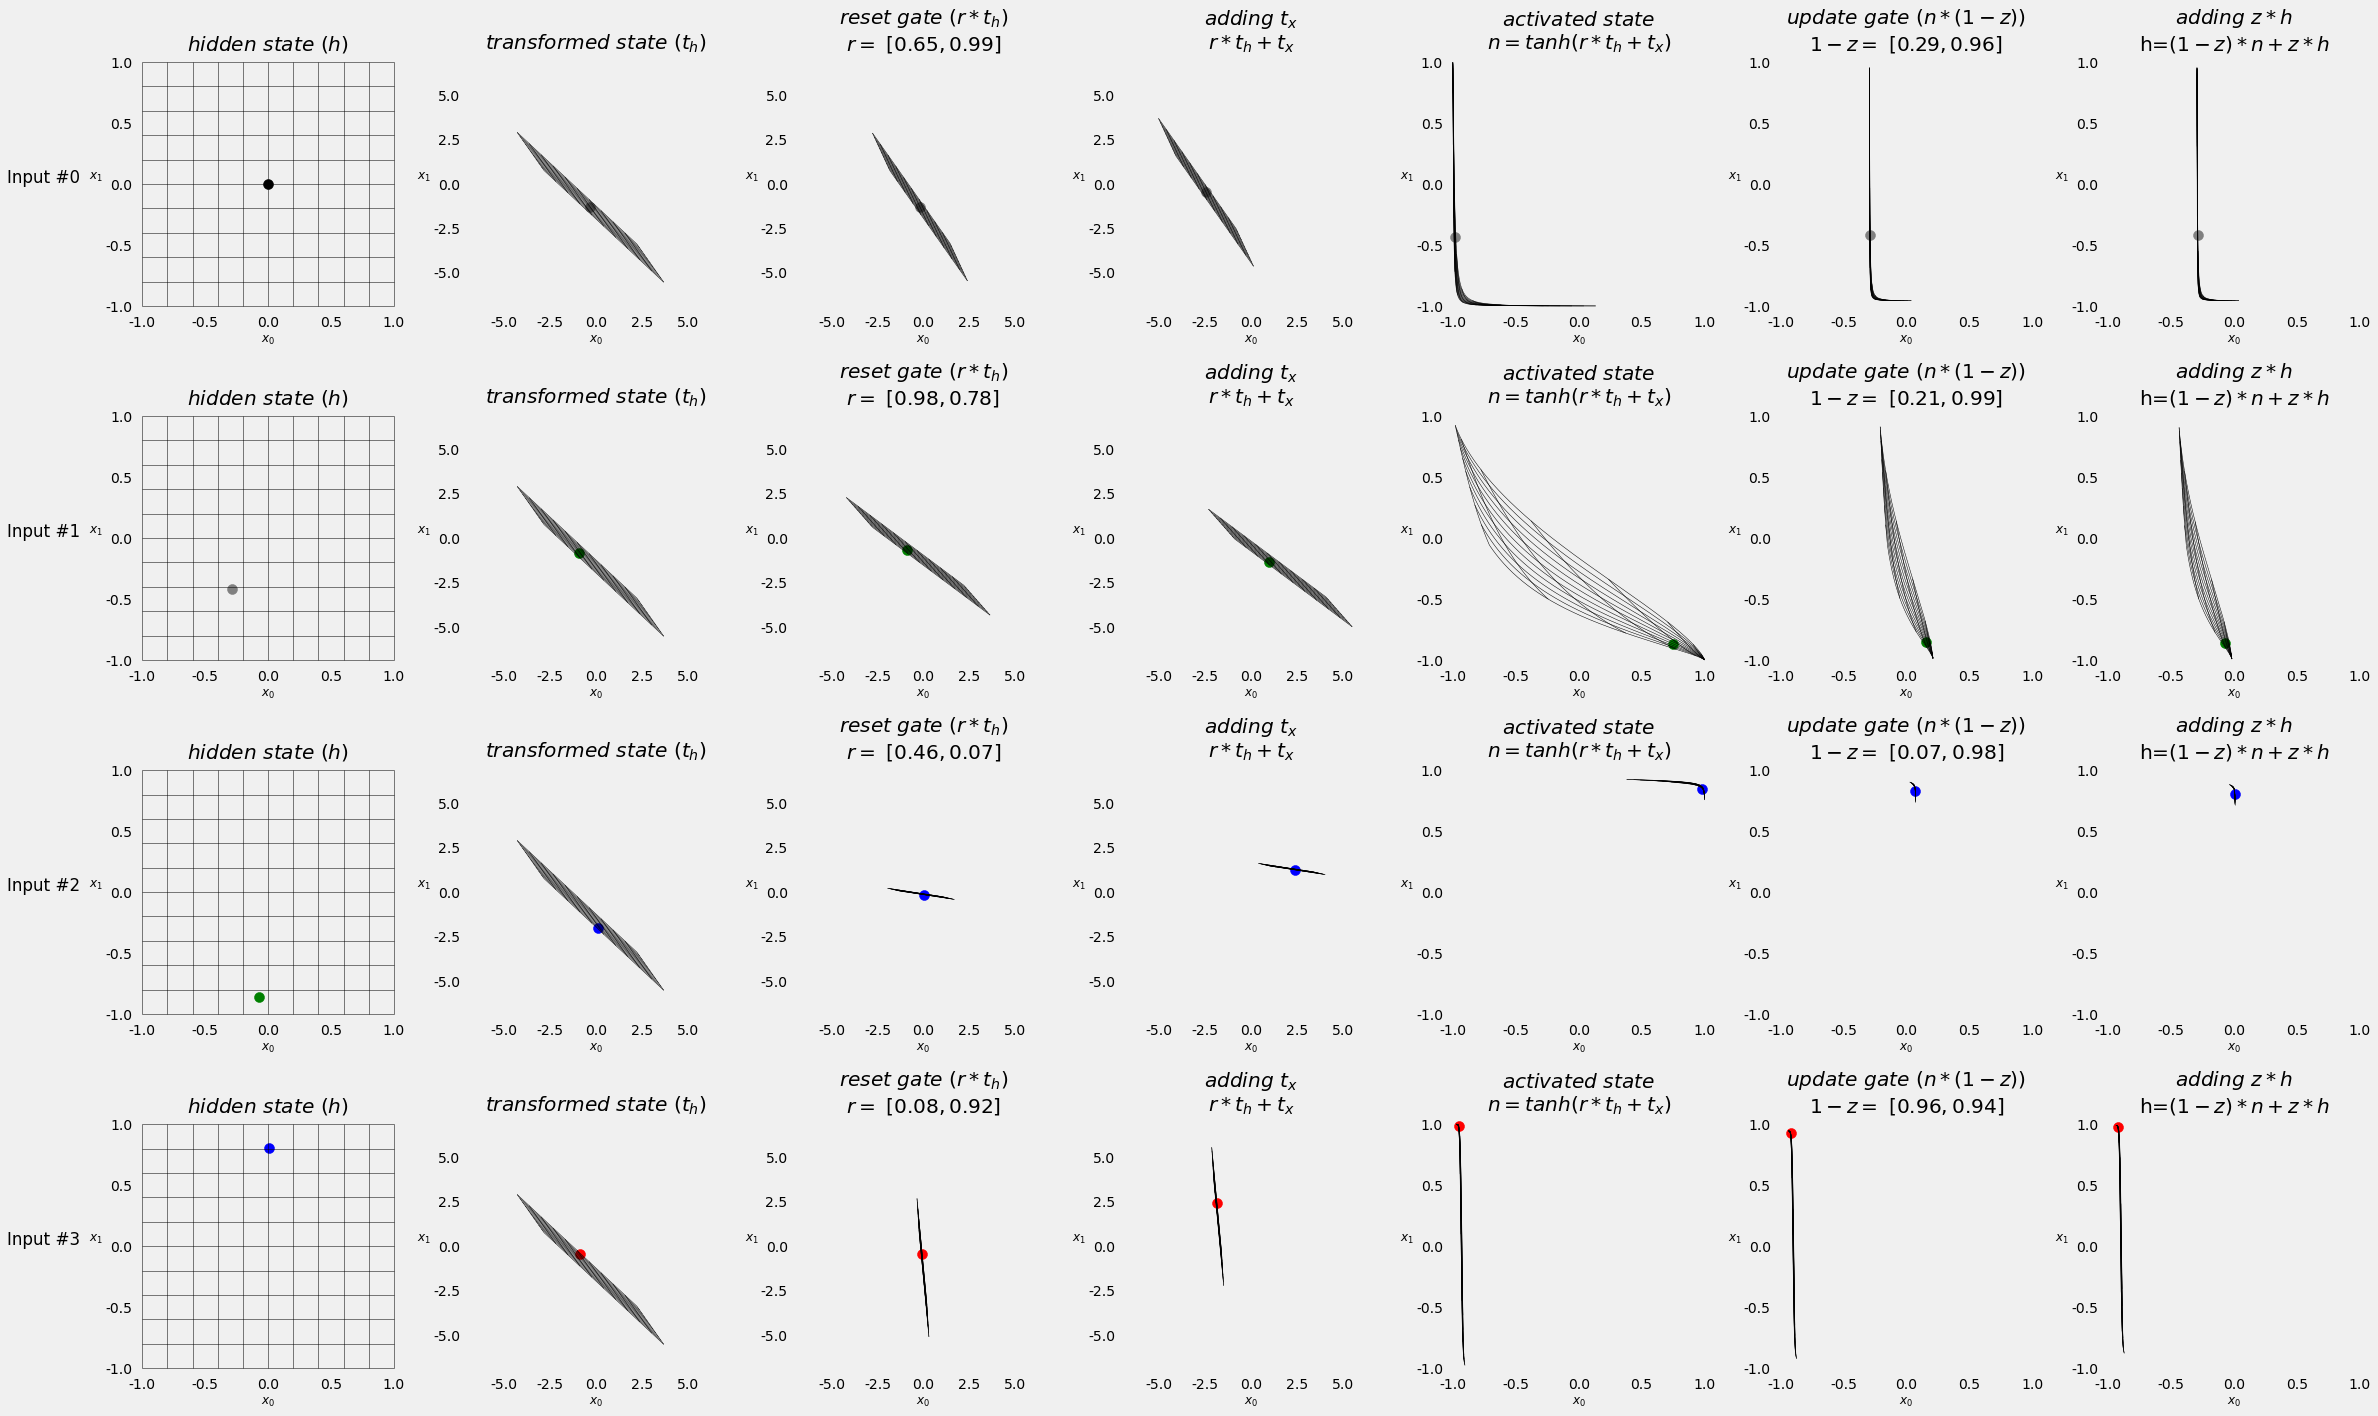

In [23]:
fig = figure22(model.basic_rnn)

## Square Model: LSTM

### Model Configuration

In [24]:
class SquareModelLSTM(nn.Module):
    def __init__(self, n_features, hidden_dim, n_outputs):
        super(SquareModelLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.hidden = None
        self.cell = None
        # Simple LSTM
        self.basic_rnn = nn.LSTM(self.n_features, self.hidden_dim, batch_first=True) 
        # Classifier to produce as many logits as outputs        
        self.classifier = nn.Linear(self.hidden_dim, self.n_outputs)
                
    def forward(self, X):
        # X is batch first (N, L, F)
        # output is (N, L, H)
        # final hidden state is (1, N, H)
        # final cell state is (1, N, H)
        batch_first_output, (self.hidden, self.cell) = self.basic_rnn(X)
        
        # only last item in sequence (N, 1, H)
        last_output = batch_first_output[:, -1]
        # classifier will output (N, 1, n_outputs)
        out = self.classifier(last_output)
        
        # final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)

### Model Configuration & Training

In [25]:
torch.manual_seed(21)
model = SquareModelLSTM(n_features=2, hidden_dim=2, n_outputs=1)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [26]:
sbs_lstm = StepByStep(model, loss, optimizer)
sbs_lstm.set_loaders(train_loader, test_loader)
sbs_lstm.train(100)

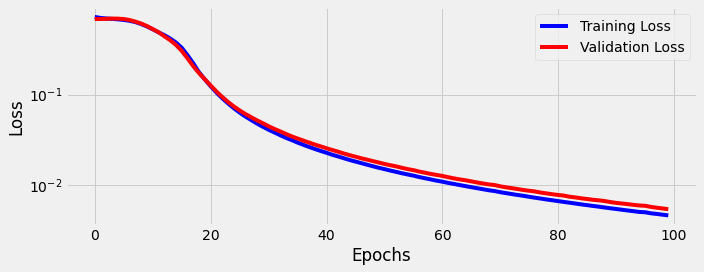

In [27]:
fig = sbs_lstm.plot_losses()

In [28]:
StepByStep.loader_apply(test_loader, sbs_lstm.correct)

tensor([[53, 53],
        [75, 75]])

## Visualizing the Hidden States

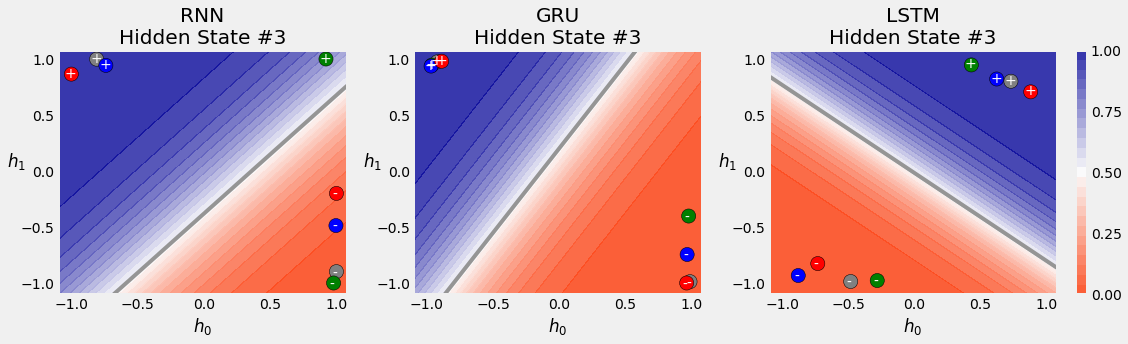

In [29]:
fig = figure25(sbs_rnn.model, sbs_gru.model, sbs_lstm.model)

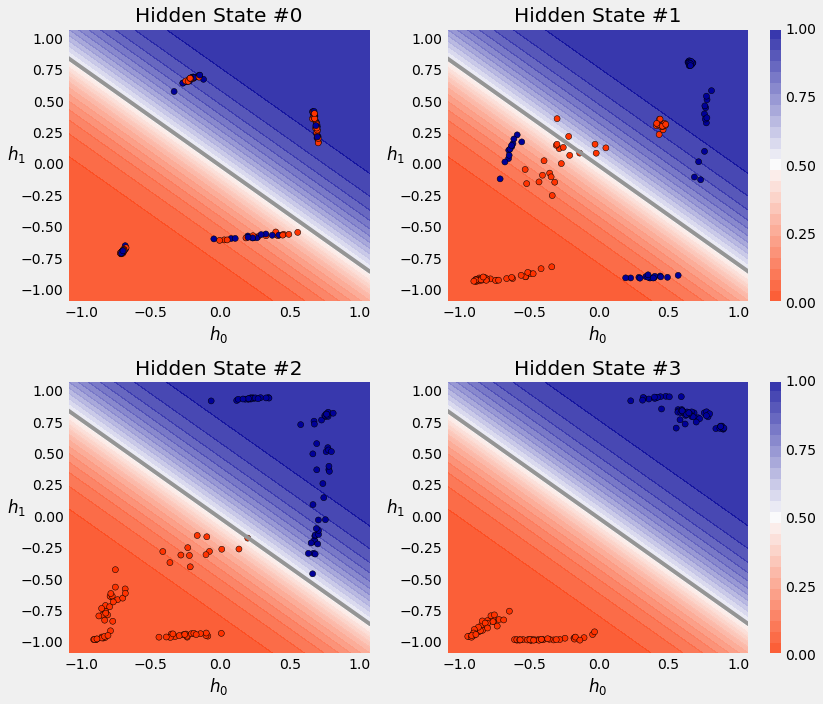

In [30]:
fig = hidden_states_contour(model, points, directions)

## Variable-Length Sequences

In [31]:
s0 = points[0]      # 4 data points
s1 = points[1][2:]  # 2 data points
s2 = points[2][1:]  # 3 data points

s0.shape, s1.shape, s2.shape

((4, 2), (2, 2), (3, 2))

### Padding

In [32]:
all_seqs = [s0, s1, s2]
torch.as_tensor(all_seqs)

ValueError: expected sequence of length 4 at dim 1 (got 2)

In [33]:
seq_tensors = [torch.as_tensor(seq).float() for seq in all_seqs]
padded = rnn_utils.pad_sequence(seq_tensors, batch_first=True)
padded

tensor([[[ 1.0349,  0.9661],
         [ 0.8055, -0.9169],
         [-0.8251, -0.9499],
         [-0.8670,  0.9342]],

        [[-1.0911,  0.9254],
         [-1.0771, -1.0414],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000]],

        [[-1.1247, -0.9683],
         [ 0.8182, -0.9944],
         [ 1.0081,  0.7680],
         [ 0.0000,  0.0000]]])

In [34]:
torch.manual_seed(11)
rnn = nn.RNN(2, 2, batch_first=True)

In [35]:
output_padded, hidden_padded = rnn(padded)
output_padded

tensor([[[-0.6388,  0.8505],
         [-0.4215,  0.8979],
         [ 0.3792,  0.3432],
         [ 0.3161, -0.1675]],

        [[ 0.2911, -0.1811],
         [ 0.3051,  0.7055],
         [ 0.0052,  0.5819],
         [-0.0642,  0.6012]],

        [[ 0.3385,  0.5927],
         [-0.3875,  0.9422],
         [-0.4832,  0.6595],
         [-0.1007,  0.5349]]], grad_fn=<TransposeBackward1>)

In [36]:
hidden_padded.permute(1, 0, 2)

tensor([[[ 0.3161, -0.1675]],

        [[-0.0642,  0.6012]],

        [[-0.1007,  0.5349]]], grad_fn=<PermuteBackward>)

### Packing

In [37]:
packed = rnn_utils.pack_sequence(seq_tensors, enforce_sorted=False)
packed

PackedSequence(data=tensor([[ 1.0349,  0.9661],
        [-1.1247, -0.9683],
        [-1.0911,  0.9254],
        [ 0.8055, -0.9169],
        [ 0.8182, -0.9944],
        [-1.0771, -1.0414],
        [-0.8251, -0.9499],
        [ 1.0081,  0.7680],
        [-0.8670,  0.9342]]), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=tensor([0, 2, 1]), unsorted_indices=tensor([0, 2, 1]))

![](images/packed_seq_inddata.png)

![](images/packed_seq_data.png)

In [38]:
(packed.data[[0, 3, 6, 8]] == seq_tensors[0]).all()

tensor(True)

In [39]:
output_packed, hidden_packed = rnn(packed)
output_packed, hidden_packed

(PackedSequence(data=tensor([[-0.6388,  0.8505],
         [ 0.3385,  0.5927],
         [ 0.2911, -0.1811],
         [-0.4215,  0.8979],
         [-0.3875,  0.9422],
         [ 0.3051,  0.7055],
         [ 0.3792,  0.3432],
         [-0.4832,  0.6595],
         [ 0.3161, -0.1675]], grad_fn=<CatBackward>), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=tensor([0, 2, 1]), unsorted_indices=tensor([0, 2, 1])),
 tensor([[[ 0.3161, -0.1675],
          [ 0.3051,  0.7055],
          [-0.4832,  0.6595]]], grad_fn=<IndexSelectBackward>))

In [40]:
hidden_packed == hidden_padded

tensor([[[ True,  True],
         [False, False],
         [False, False]]])

In [41]:
output_packed.data[[2, 5]] # x1 sequence

tensor([[ 0.2911, -0.1811],
        [ 0.3051,  0.7055]], grad_fn=<IndexBackward>)

### Unpacking (to padded)

In [42]:
output_unpacked, seq_sizes = rnn_utils.pad_packed_sequence(output_packed, batch_first=True)
output_unpacked, seq_sizes

(tensor([[[-0.6388,  0.8505],
          [-0.4215,  0.8979],
          [ 0.3792,  0.3432],
          [ 0.3161, -0.1675]],
 
         [[ 0.2911, -0.1811],
          [ 0.3051,  0.7055],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],
 
         [[ 0.3385,  0.5927],
          [-0.3875,  0.9422],
          [-0.4832,  0.6595],
          [ 0.0000,  0.0000]]], grad_fn=<IndexSelectBackward>),
 tensor([4, 2, 3]))

In [43]:
output_unpacked[:, -1]

tensor([[ 0.3161, -0.1675],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000]], grad_fn=<SelectBackward>)

In [44]:
seq_idx = torch.arange(seq_sizes.size(0))
output_unpacked[seq_idx, seq_sizes-1]

tensor([[ 0.3161, -0.1675],
        [ 0.3051,  0.7055],
        [-0.4832,  0.6595]], grad_fn=<IndexBackward>)

### Packing (from padded)

In [45]:
len_seqs = [len(seq) for seq in all_seqs]
len_seqs

[4, 2, 3]

In [46]:
packed = rnn_utils.pack_padded_sequence(padded, len_seqs, enforce_sorted=False, batch_first=True)
packed

PackedSequence(data=tensor([[ 1.0349,  0.9661],
        [-1.1247, -0.9683],
        [-1.0911,  0.9254],
        [ 0.8055, -0.9169],
        [ 0.8182, -0.9944],
        [-1.0771, -1.0414],
        [-0.8251, -0.9499],
        [ 1.0081,  0.7680],
        [-0.8670,  0.9342]]), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=tensor([0, 2, 1]), unsorted_indices=tensor([0, 2, 1]))

### Variable-Length Dataset

In [47]:
var_points, var_directions = generate_sequences(variable_len=True)
var_points[:2]

[array([[ 1.12636495,  1.1570899 ],
        [ 0.87384513, -1.00750892],
        [-0.9149893 , -1.09150317],
        [-1.0867348 ,  1.07731667]]),
 array([[ 0.92250954, -0.89887678],
        [ 1.0941646 ,  0.92300589]])]

## Data Preparation

In [49]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = [torch.as_tensor(s).float() for s in x]
        self.y = torch.as_tensor(y).float().view(-1, 1)
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)
    
train_var_data = CustomDataset(var_points, var_directions)

In [50]:
train_var_loader = DataLoader(train_var_data, batch_size=16, shuffle=True)
next(iter(train_var_loader))

RuntimeError: stack expects each tensor to be equal size, but got [4, 2] at entry 0 and [2, 2] at entry 1

### Collate Function

In [51]:
def pack_collate(batch):
    X = [item[0] for item in batch]
    y = [item[1] for item in batch]
    X_pack = rnn_utils.pack_sequence(X, enforce_sorted=False)

    return X_pack, torch.as_tensor(y).view(-1, 1)

In [52]:
# list of tuples returned by the dataset
dummy_batch = [train_var_data[0], train_var_data[1]]
dummy_x, dummy_y = pack_collate(dummy_batch)
dummy_x

PackedSequence(data=tensor([[ 1.1264,  1.1571],
        [ 0.9225, -0.8989],
        [ 0.8738, -1.0075],
        [ 1.0942,  0.9230],
        [-0.9150, -1.0915],
        [-1.0867,  1.0773]]), batch_sizes=tensor([2, 2, 1, 1]), sorted_indices=tensor([0, 1]), unsorted_indices=tensor([0, 1]))

In [53]:
train_var_loader = DataLoader(train_var_data, batch_size=16, shuffle=True, collate_fn=pack_collate)
x_batch, y_batch = next(iter(train_var_loader))

## Square Model IV: Packed

In [55]:
class SquareModelPacked(nn.Module):
    def __init__(self, n_features, hidden_dim, n_outputs):
        super(SquareModelPacked, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.hidden = None
        self.cell = None
        # Simple LSTM
        self.basic_rnn = nn.LSTM(self.n_features, self.hidden_dim, bidirectional=True) 
        # Classifier to produce as many logits as outputs        
        self.classifier = nn.Linear(2 * self.hidden_dim, self.n_outputs)

    def forward(self, X):       
        # X is a PACKED sequence now
        
        # output is PACKED
        # final hidden state is (2, N, H) - bidirectional
        # final cell state is (2, N, H) - bidirectional
        rnn_out, (self.hidden, self.cell) = self.basic_rnn(X)
        # unpack the output (N, L, 2*H)
        batch_first_output, seq_sizes = rnn_utils.pad_packed_sequence(rnn_out, batch_first=True)
        
        # only last item in sequence (N, 1, 2*H)
        seq_idx = torch.arange(seq_sizes.size(0))
        last_output = batch_first_output[seq_idx, seq_sizes-1]
        # classifier will output (N, 1, n_outputs)
        out = self.classifier(last_output)
                
        # final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)

## Model Configuration & Training

In [56]:
torch.manual_seed(21)
model = SquareModelPacked(n_features=2, hidden_dim=2, n_outputs=1)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [57]:
sbs_packed = StepByStep(model, loss, optimizer)
sbs_packed.set_loaders(train_var_loader)
sbs_packed.train(100)

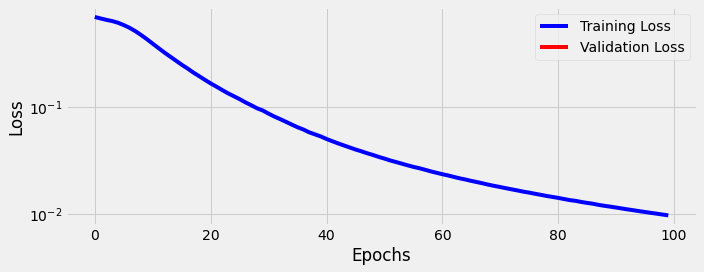

In [58]:
fig = sbs_packed.plot_losses()

In [59]:
StepByStep.loader_apply(train_var_loader, sbs_packed.correct)

tensor([[66, 66],
        [62, 62]])